Open a binary file explicitly in binary mode using "rb" (r = "read", b = "binary")

In [1]:
fp = open("example2","rb")

Read the first 100 bytes *(The b at the beginning of the string marks it as a byte string)*

In [2]:
fp.read(100)

b'RIFFF\x1f2\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x00\x10\x00LIST\x1a\x00\x00\x00INFOISFT\x0e\x00\x00\x00Lavf56.40.101\x00data\x00\x1f2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

Read the whole file into memory

In [3]:
data = open("example2","rb").read()

Check that Python and the file system agree on the number of bytes in the file (~3.2 MB)

In [4]:
len(data)

3284814

In [5]:
!ls -l example2

-rw-rw-r-- 1 bms270 bms270 3284814 Apr 25  2017 example2


Let's take a look at the first 100 bytes again

In [6]:
data[:100]

b'RIFFF\x1f2\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x00\x10\x00LIST\x1a\x00\x00\x00INFOISFT\x0e\x00\x00\x00Lavf56.40.101\x00data\x00\x1f2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

The "WAVEfmt" string is a clue that we may be dealing with a WAV format audio file.  A look at the <A href="http://www-mmsp.ece.mcgill.ca/Documents/AudioFormats/WAVE/WAVE.html">WAV spec</A> confirms our suspicions and gives us the necessary details for decoding the file (analogous to knowing the rules linking a TATA box to a transcriptional start site)

We'll scan for the first data subchunk, identified by a "data" label.  *Note that because we read a **byte** string, we need to mark our search string as a byte string as well*

In [7]:
data.find(b"data")

70

In [8]:
data[70:74]

b'data'

The next 4 bytes give the size of this data subchunk, in "little endian" encoding (least significant byte first).  

This is equivalent to writing a decimal number backwards.  *I.e.*, conventionally, we write twelve with the most significant (tens) digit first: "12".  In little endian encoding we would write it "21".

In [9]:
data[74:78]

b'\x00\x1f2\x00'

We'll write a helper function to decode little endian values

In [10]:
def littleBytes(a):
    # Initialize decoded value to 0
    r = 0
    # Value is given _least_ significant byte first,
    # so we'll look over the bytes in reverse order,
    # taking the most significant byte first
    for i in reversed(a):
        # Left shift the current value 8 bits.
        # This is equivalent to multiplying by 2**8=256.
        # Think of it as adding a zero on the right of
        # a decimal number (equivalent to multiplying by 10)
        r = r << 8
        # Interpret the current byte as a number and put
        # it in the right-most "ones" position (which we
        # just vacated with our left shift)
        r += i
    return r

Now we're ready to decode the size of the data subchunk

In [11]:
littleBytes(data[74:78])

3284736

So, this data subchunk is close to the full length of the file (~3.2 MB), implying that all of the audio content is in a single data block.

The data block is simply a list of little endian samples, which we can think of as measurements of displacements of a microphone of speaker membrane at evenly spaced points in time.  Let's take a look at the first 10000 bytes of data (2500 samples)

In [12]:
x = [littleBytes(data[i:i+4]) for i in range(78,10078,4)]

In [13]:
min(x),max(x)

(0, 4294967295)

Note that this spans the full range available to 4 byte unsigned integer data

In [14]:
256**4-1

4294967295

Let's plot the first 1000 samples

In [15]:
%matplotlib nbagg
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


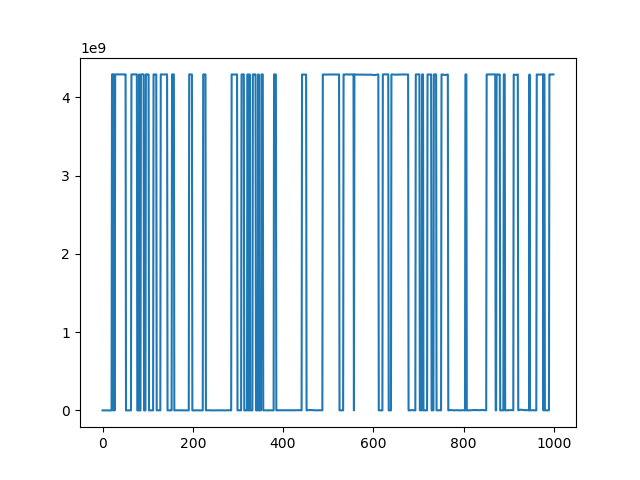

In [16]:
fig = plt.figure()
plt.plot(x[:1000])

* At first glance, it looks like all of the values all either the minimum ($0$) or maximum ($256^4-1$) value.  
* If we zoom in on the plot, we can see small deviations away from these values
* This is a clue that we should interpret the values as *signed* integers:
  * Zero is zero
  * Values in the first half of the range are positive values counting up from zero
  * Values in the second half of the range are negative values, counting down to zero.

With this signed interpretation of the data, we can re-plot the first 1000 samples and get something that looks like a waveform

In [17]:
a = 256**4

<IPython.core.display.Javascript object>


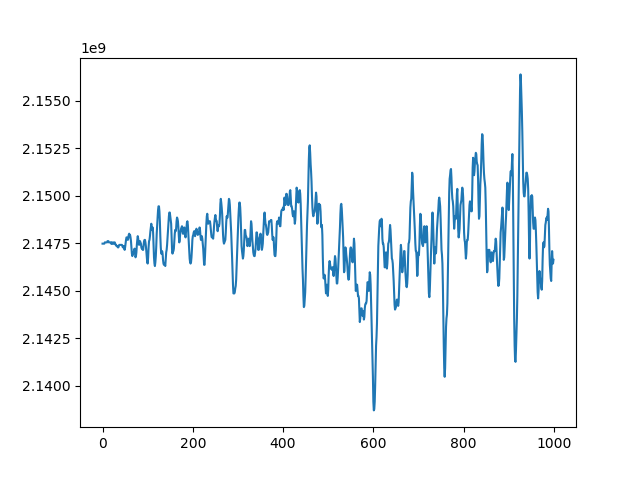

In [18]:
fig = plt.figure()
plt.plot([(i - a/2) % a for i in x[:1000]])

Plotting the full 10000 samples in x shows increasing volume

<IPython.core.display.Javascript object>


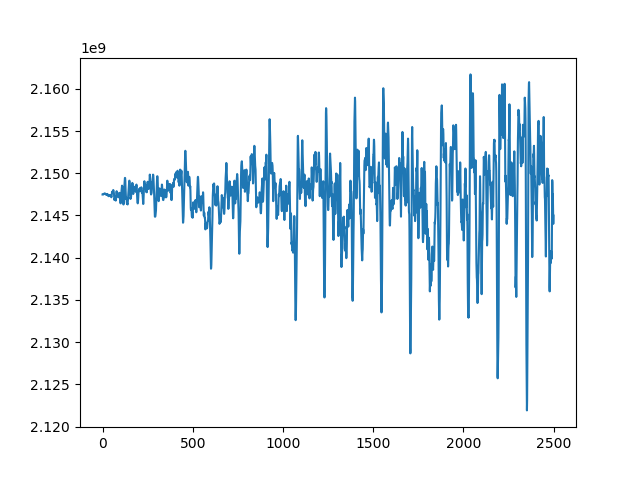

In [19]:
fig = plt.figure()
plt.plot([(i - a/2) % a for i in x])

To visualize the full file, rather than trying to plot 3.2 million points directly (which might overtax matplotlib's nbagg backend) we'll subsample by increasing the step size in our call to **range** (making sure that the step is a multiple of four, so that we stay in the right reading frame)

In [20]:
x = [littleBytes(data[i:i+4]) for i in range(78,len(data),160)]
len(x)

20530

<IPython.core.display.Javascript object>


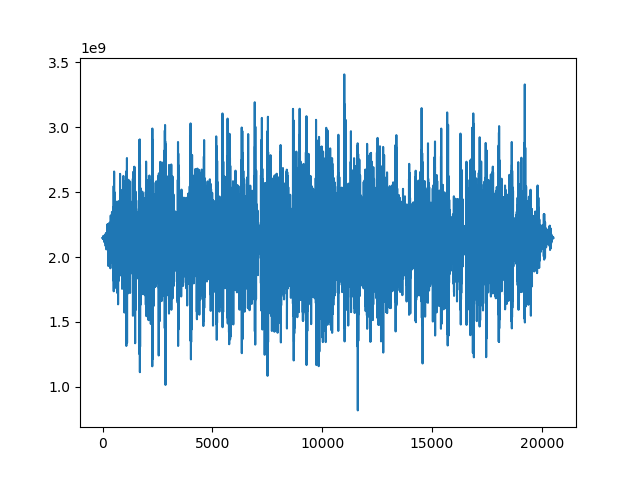

In [21]:
fig = plt.figure()
plt.plot([(i - a/2) % a for i in x])

This gives a good view of the volume envelope for the full file.  If we were interested in a particular time range, we could plot the full set of samples for just that range.